# COVID19 International

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Python-setup" data-toc-modified-id="Python-setup-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Python setup</a></span></li><li><span><a href="#Get-the-raw-data-and-adjust-for-anomalies" data-toc-modified-id="Get-the-raw-data-and-adjust-for-anomalies-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Get the raw data and adjust for anomalies</a></span><ul class="toc-item"><li><span><a href="#COVID-data-retrieval" data-toc-modified-id="COVID-data-retrieval-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>COVID data retrieval</a></span></li></ul></li><li><span><a href="#Adjust-for-late-data---treat-as-missing" data-toc-modified-id="Adjust-for-late-data---treat-as-missing-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Adjust for late data - treat as missing</a></span><ul class="toc-item"><li><span><a href="#Adjust-the-data-for-negative-growth-and-outlier-spikes" data-toc-modified-id="Adjust-the-data-for-negative-growth-and-outlier-spikes-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Adjust the data for negative growth and outlier spikes</a></span></li></ul></li><li><span><a href="#World-Maps" data-toc-modified-id="World-Maps-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>World Maps</a></span><ul class="toc-item"><li><span><a href="#Fully-vaccinated" data-toc-modified-id="Fully-vaccinated-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Fully vaccinated</a></span></li><li><span><a href="#Latest-daily-cases-and-deaths-per-million-population" data-toc-modified-id="Latest-daily-cases-and-deaths-per-million-population-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Latest daily cases and deaths per million population</a></span></li><li><span><a href="#Cumulative-cases/deaths-per-one-thousand-population" data-toc-modified-id="Cumulative-cases/deaths-per-one-thousand-population-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Cumulative cases/deaths per one thousand population</a></span></li></ul></li><li><span><a href="#Top-40-Charts" data-toc-modified-id="Top-40-Charts-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Top 40 Charts</a></span></li><li><span><a href="#Public-health-measures" data-toc-modified-id="Public-health-measures-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Public health measures</a></span></li><li><span><a href="#Recent-daily-cases/deaths-per-million-population" data-toc-modified-id="Recent-daily-cases/deaths-per-million-population-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Recent daily cases/deaths per million population</a></span></li><li><span><a href="#Weekly-cases-and-deaths" data-toc-modified-id="Weekly-cases-and-deaths-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Weekly cases and deaths</a></span></li><li><span><a href="#The-End" data-toc-modified-id="The-End-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>The End</a></span></li></ul></div>

## Python setup

In [1]:
# system imports
import sys
from pathlib import Path

#analytic imports
import datetime
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.units as munits
import seaborn as sns
import statsmodels.api as sm
import geopandas as gpd  # $ conda install -c anaconda pip
                         # $ pip install geopandas
                         # $ pip install Fiona
import iso3166           # installed from conda-forge

# COVID19 specific imports
sys.path.append(r'../bin')
import plotstuff as ps

# directory
CHART_DIRECTORY = '../charts'
Path(CHART_DIRECTORY).mkdir(parents=True, exist_ok=True)
CHART_DIRECTORY += '/!Int-'
I_PREFIX = '!'

# display settings
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

# plotting stuff
plt.style.use('ggplot')

# matplotlib stuff for date formatting xticklabels
converter = mdates.ConciseDateConverter()
munits.registry[np.datetime64] = converter
munits.registry[datetime.date] = converter
munits.registry[datetime.datetime] = converter
munits.registry[pd.Timestamp] = converter
munits.registry[pd.Period] = converter

std_plot_settings = {
    'chart_directory': CHART_DIRECTORY+I_PREFIX, 
    'show': True,
    'margins': 0.02,
    # Note: rfooter set below ...
}

RECENT = 183 # days - for recent plots

## Get the raw data and adjust for anomalies

### COVID data retrieval

iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,reproduction_rate,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,weekly_icu_admissions,weekly_icu_admissions_per_million,weekly_hosp_admissions,weekly_hosp_admissions_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,tests_units,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,new_vaccinations_smoothed_per_million,new_people_vaccinated_smoothed,new_people_vaccinated_smoothed_per_hundred,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million

In [2]:
# global repository of the raw data
_data_lake = {}

# data extraction map
data_extraction_map = {
    #table name      #pivot value
    'cases':         'total_cases',
    'deaths':        'total_deaths',
    'vaccine doses': 'total_vaccinations',
    'people vaccinated': 'people_vaccinated',
    'fully vaccinated': 'people_fully_vaccinated',
    'stringency index': 'stringency_index',
    'fully vaxxed rate': 'people_fully_vaccinated_per_hundred',
    'hospital patients': 'hosp_patients',
}

In [3]:
def get_OWID_data():
    """Return a tuple:
       1.  Dictionary of DataFrames, based on the 
           data_extraction_map. Also extract 
           national populations and include in the 
           dictionary.
       2.  A source string for the data."""

    throw_away = ['Africa', 'Asia', 'Europe', 'European Union', 'North America', 
                  'Oceania', 'International', 'South America', 'Upper middle income', 
                  'HIGH INCOME', 'Low income', 'Lower middle income', 'World']   
    throw_away = [x.lower() for x in throw_away]
    
    # get the raw data from the Internet
    URL = ('https://github.com/owid/covid-19-data/raw/master/public/data/owid-covid-data.csv')

    global _data_lake
    if URL not in _data_lake:
        raw_data = pd.read_csv(URL, header=0)
        print('Data retrieved from the internet')
        _data_lake[URL] = raw_data
    raw_data =  _data_lake[URL].copy()

    # extract the tables we want, using the get_map above
    gotten = {}
    for name, value in data_extraction_map.items():
        data = raw_data.pivot(columns='location', 
                              index='date', 
                              values=value)
        data = data.dropna(axis='columns', how='all')
        data = data.dropna(axis='index', how='all')
        data.index = pd.DatetimeIndex(data.index)
        data = data.sort_index(ascending=True)
        
        keep = [c for c in data.columns if c.lower() not in throw_away]
        data = data[keep]
        
        # extra treatment for vaccinations, as these records
        # are quite patchy for some nations
        if name in ('vaccine doses', 'people vaccinated', 
                    'fully vaccinated'):
            data = data.interpolate(limit_area='inside')
        
        gotten[name] = data

    # also collect population data for each country
    population = raw_data.pivot(columns='location', 
                                index='date', 
                                values='population')
    keep = [c for c in population.columns if c.lower() not in throw_away]
    population = population[keep]
    populations = {}
    for p in population.columns:
        address = population[p].last_valid_index()
        if address is None:
            continue
        populations[p] = population[p].loc[address]
    gotten['population'] = pd.Series(populations)
    
    # source string
    source = f'Source: OWID {gotten["cases"].index[-1].date()}'
    
    # return the lot
    return (gotten, source)

In [4]:
data_dict, source = get_OWID_data()
std_plot_settings['rfooter'] = source

Data retrieved from the internet


In [5]:
data_dict.keys()

dict_keys(['cases', 'deaths', 'vaccine doses', 'people vaccinated', 'fully vaccinated', 'stringency index', 'fully vaxxed rate', 'hospital patients', 'population'])

## Adjust for late data - treat as missing

In [6]:
def find_late_zeros(df: pd.DataFrame) -> pd.DataFrame:
    missing = (
        (df == 0)
        .astype('float')
        .replace(1.0, np.nan)
        .bfill()
        .isna()
    )
    return missing


def mark_late_probaby_missing(dict_index:str) -> None:
    """Replace the data at the end of each columns
       with NaN if it looks like missing data."""

    ROLLING_PERIOD = 7
    THRESHOLD = 0.9 # ok if <= threshold ave cases/deaths per day in the last period
    FROM_END = 10 # days - and only for up to 10 days from the end ...
    
    # identify where we might have gaps
    data_cum = data_dict[dict_index].fillna(0) # cumulative data
    previous = data_cum.index.min() - pd.Timedelta(days=1)
    empty_row = pd.Series(0, index=data_cum.columns)
    empty_row.name = previous
    data_cum = data_cum.append(empty_row).sort_index()
    data_daily = data_cum.diff()
    missing = find_late_zeros(data_daily)
    
    # check if the tail-end gaps in data look genuine
    data_daily = data_daily.where(~missing, other=np.nan)
    last_index = data_daily.index[-1]
    rolling_average = data_daily.rolling(ROLLING_PERIOD).mean()
    for column in data_cum.columns:
        
        # check whether we need to do anything.
        series = data_cum[column]
        if series.isna().all():
            continue # nothing here
        
        last_valid = series.last_valid_index()
        if last_valid == last_index:
            continue
        
        if rolling_average[column].loc[last_valid] <= THRESHOLD:
            missing[column] = False
            continue
            
        if ((last_index - last_valid) / pd.Timedelta(days=1)) > FROM_END:
            missing[column] = False
            continue

    data_cum = data_cum.where(~missing, other=np.nan)
        
    data_dict[dict_index] = data_cum
    
for name in ('cases', 'deaths'):
    mark_late_probaby_missing(name)

In [7]:
# number of missing data items in the last row of cases
data_dict['cases'].iloc[-1].isna().sum()

48

In [8]:
# number of missing data items in the 2nd last row of cases
data_dict['cases'].iloc[-2].isna().sum()

26

In [9]:
# number of missing data items in the last row of deaths
data_dict['deaths'].iloc[-1].isna().sum()

78

### Adjust the data for negative growth and outlier spikes

In [10]:
# make adjustments to the data if necessary
def make_data_corrections(data_dict, source):
    
    for name in ('cases', 'deaths'):
        # adjust raw data for anomalies
        (raw_daily, adj_daily, adj_cum) = (
            ps.dataframe_correction(data_dict[name],
                                    verbose=False)
        )
        data_dict[name + '_raw_daily'] = raw_daily
        data_dict[name + '_adj_daily'] = adj_daily
        data_dict[name + '_adj_cum']   = adj_cum
        
        # remember when we have adjusted the data
        quality = pd.Series(source, index = data_dict[name].columns)
        rd = data_dict[name + '_raw_daily']
        ad = data_dict[name + '_adj_daily']
        for col in quality.index:
            if (rd[col] != ad[col]).any():
                quality[col] += '; outliers adjusted'
        data_dict[name + '_quality'] = quality
        
    return data_dict

In [11]:
# this takes a minute or two
data_dict = make_data_corrections(data_dict, source)
print(data_dict.keys())

dict_keys(['cases', 'deaths', 'vaccine doses', 'people vaccinated', 'fully vaccinated', 'stringency index', 'fully vaxxed rate', 'hospital patients', 'population', 'cases_raw_daily', 'cases_adj_daily', 'cases_adj_cum', 'cases_quality', 'deaths_raw_daily', 'deaths_adj_daily', 'deaths_adj_cum', 'deaths_quality'])


## World Maps

In [12]:
#list(iso3166.countries)

In [13]:
# National name mapping to iso
names = {
    # OWID_Name, ISO_3166_Name
    'Bolivia': 'Bolivia, Plurinational State of',
    'Bonaire Sint Eustatius and Saba': 'Bonaire, Sint Eustatius and Saba',
    'British Virgin Islands': 'Virgin Islands, British',
    'Brunei': 'Brunei Darussalam',
    'Cape Verde': 'Cabo Verde',
    "Cote d'Ivoire": "Côte d'Ivoire",
    'Curacao': 'Curaçao',
    'Democratic Republic of Congo': 'Congo, Democratic Republic of the',
    'Faeroe Islands': 'Faroe Islands',
    'Falkland Islands': 'Falkland Islands (Malvinas)',
    'Iran': 'Iran, Islamic Republic of',
    'Laos': "Lao People's Democratic Republic",
    'Micronesia (country)': 'Micronesia, Federated States of',
    'Moldova': 'Moldova, Republic of',
    'Russia': 'Russian Federation',
    'Saint Helena': 'Saint Helena, Ascension and Tristan da Cunha',
    'South Korea': 'Korea, Republic of',
    'Syria': 'Syrian Arab Republic',
    'Tanzania': 'Tanzania, United Republic of',
    'Timor': 'Timor-Leste',
    'United Kingdom': 'United Kingdom of Great Britain and Northern Ireland',
    'United States': 'United States of America',
    'Venezuela': 'Venezuela, Bolivarian Republic of',
    'Vatican': 'Holy See',
    'Vietnam': 'Viet Nam',
}

In [14]:
def map_world(series, title, legend_title, source):
    
    # prepare data for mapping
    ignore = ['Northern Cyprus', ]
    for item in ignore:
        if item in series.index:
            del series[item]
    series = series.rename(names)
    score = pd.DataFrame(series) # back to DataFrame
    
    score.columns = ['Score']
    score['country'] = score.index
    score['code'] = [iso3166.countries.get(x.upper())[2] 
                     for x in score['country']]
    
    # get map data
    shapefile = ('../geo-data/ne_110m_admin_0_countries/'
        'ne_110m_admin_0_countries.shp')
    gdf = gpd.read_file(shapefile)[['ADMIN', 'ADM0_A3', 'geometry']]
    gdf.columns = ['country', 'country_code', 'geometry']
    gdf = gdf[gdf['country'] != 'Antarctica'] 
    
    merged = gdf.merge(score,
                       left_on='country_code', 
                       right_on='code', how='left')

    variable = 'Score'
    cmap = mpl.cm.get_cmap('viridis').reversed()
    cmap.set_bad('white')
    cmap.set_under('white')
    ax = merged.plot(column=variable, cmap=cmap, legend=False)
    
    # colorbar
    world_map = ax.collections[0]
    ax.grid(False)
    cb = plt.colorbar(world_map, ax=ax, orientation='horizontal')

    # legend title
    fig = ax.figure
    fig.text(0.5, 0.175, legend_title,
        ha='center', va='bottom',
        fontsize=12, # fontstyle='italic',
        color='#222222')
    
    ps.finalise_plot(ax, title=title,
                     xticklabels=[], yticklabels=[],
                     xticks=[], yticks=[],
                     rfooter=source,
                     set_size_inches=(8,5),
                     save_as=f'{CHART_DIRECTORY}'
                             f'{I_PREFIX}MAP-{title}.png',
                     show=True,
                    )

### Fully vaccinated

/var/folders/96/8bhlz_x975z93glbxq_2_yqr0000gn/T/ipykernel_7758/2742792986.py:36: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb = plt.colorbar(world_map, ax=ax, orientation='horizontal')


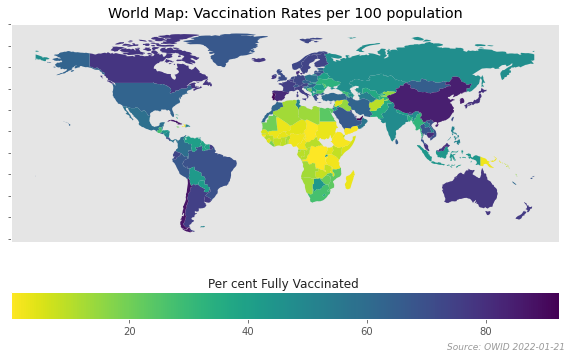

In [15]:
# map fully vaccinated
series = (
    data_dict['fully vaxxed rate']
    .dropna(how='all', axis=1)
    .ffill()
    .iloc[-1]
)
series = series.where(series <= 100, other=100)
map_world(series, 'World Map: Vaccination Rates per 100 population', 'Per cent Fully Vaccinated', source)

### Latest daily cases and deaths per million population

/var/folders/96/8bhlz_x975z93glbxq_2_yqr0000gn/T/ipykernel_7758/2742792986.py:36: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb = plt.colorbar(world_map, ax=ax, orientation='horizontal')


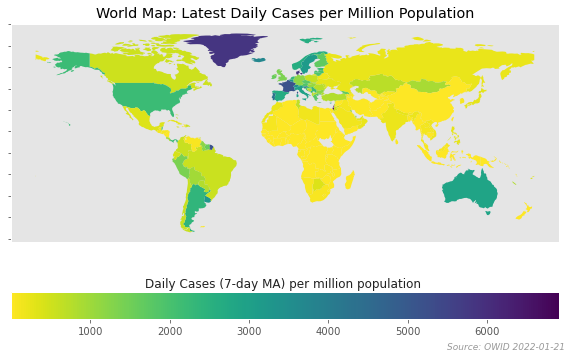

/var/folders/96/8bhlz_x975z93glbxq_2_yqr0000gn/T/ipykernel_7758/2742792986.py:36: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb = plt.colorbar(world_map, ax=ax, orientation='horizontal')


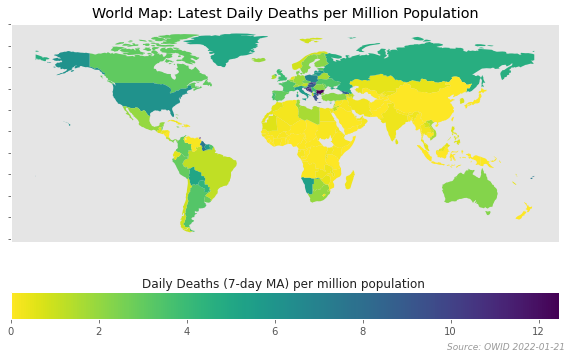

In [16]:
frame = {
    # name: description,
    'cases_raw_daily': 'Daily Cases',
    'deaths_raw_daily': 'Daily Deaths',
}

N = 7
for item, desc in frame.items():
    data = data_dict[item].rolling(N).mean()
    series = (
        (data / (data_dict['population'] / 1_000_000))
        .dropna(how='all', axis=1)
        .ffill()
        .iloc[-1]
    )
    map_world(series, 
              f'World Map: Latest {desc} per Million Population', 
              f'{desc} ({N}-day MA) per million population', source)

### Cumulative cases/deaths per one thousand population

/var/folders/96/8bhlz_x975z93glbxq_2_yqr0000gn/T/ipykernel_7758/2742792986.py:36: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb = plt.colorbar(world_map, ax=ax, orientation='horizontal')


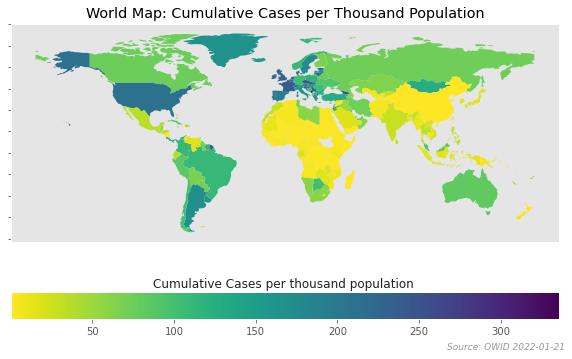

/var/folders/96/8bhlz_x975z93glbxq_2_yqr0000gn/T/ipykernel_7758/2742792986.py:36: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb = plt.colorbar(world_map, ax=ax, orientation='horizontal')


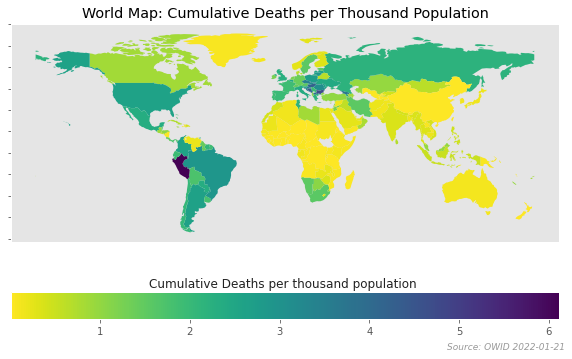

In [17]:
frame = {
    # name: description,
    'cases': 'Cases',
    'deaths': 'Deaths',
}

N = 7
for item, desc in frame.items():
    data = data_dict[item]
    series = (
        (data / (data_dict['population'] / 1_000))
        .dropna(how='all', axis=1)
        .ffill()
        .iloc[-1]
    )
    map_world(series, 
              f'World Map: Cumulative {desc} per Thousand Population', 
              f'Cumulative {desc} per thousand population', source)

## Top 40 Charts

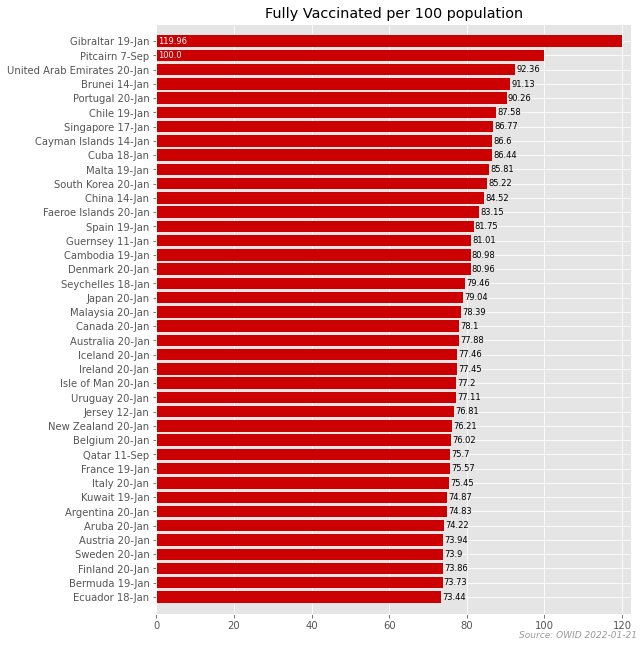

In [18]:
data= (
    data_dict['fully vaxxed rate']
    .dropna(how='all', axis=1)
)

ps.plot_final_barh(data, 
                   title=f'Fully Vaccinated per 100 population', 
                    scale_x=True, 
                    set_size_inches=(9, 9), 
                    round=3,
                    no_locator=True,
                    color='#cc0000',
                    **std_plot_settings)

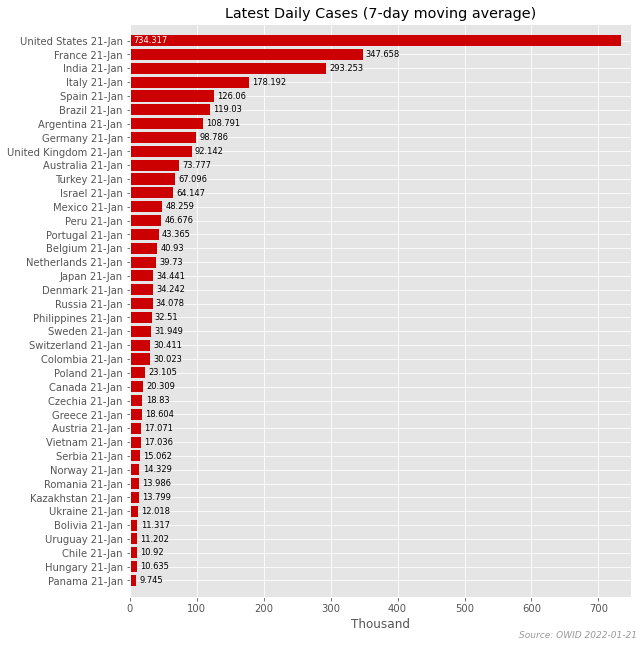

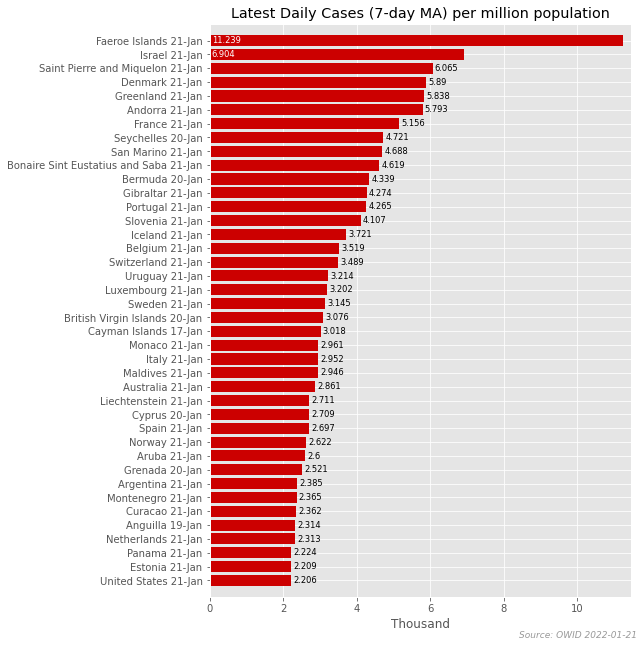

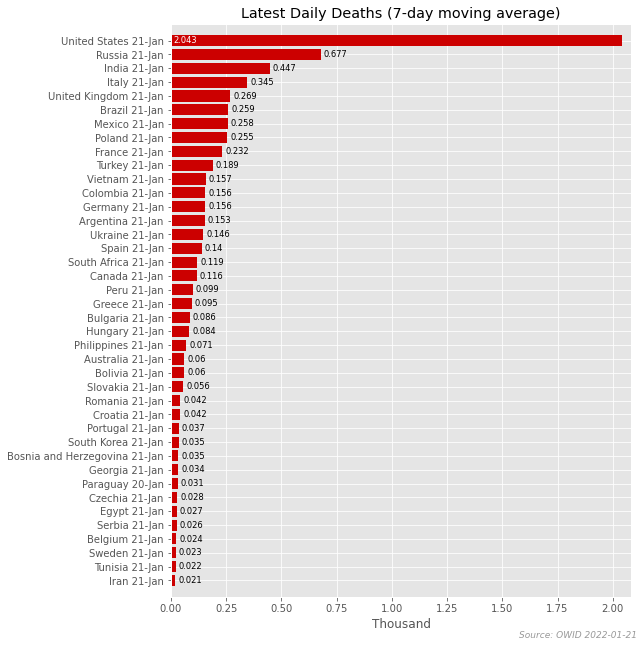

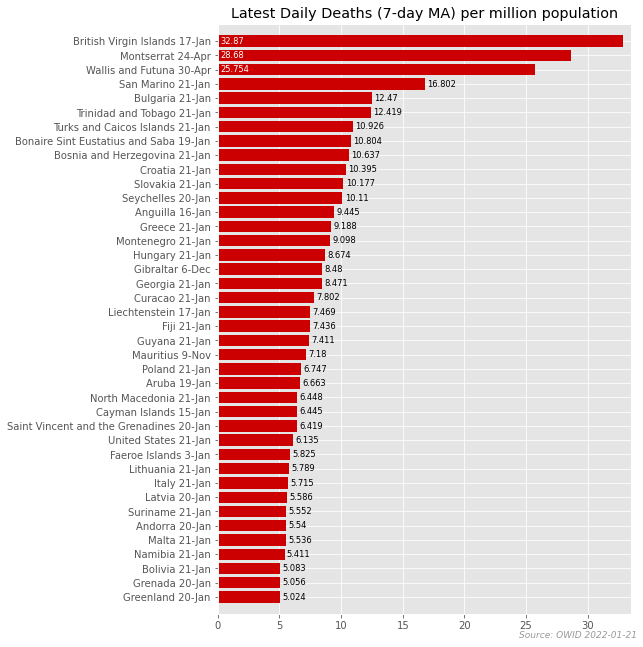

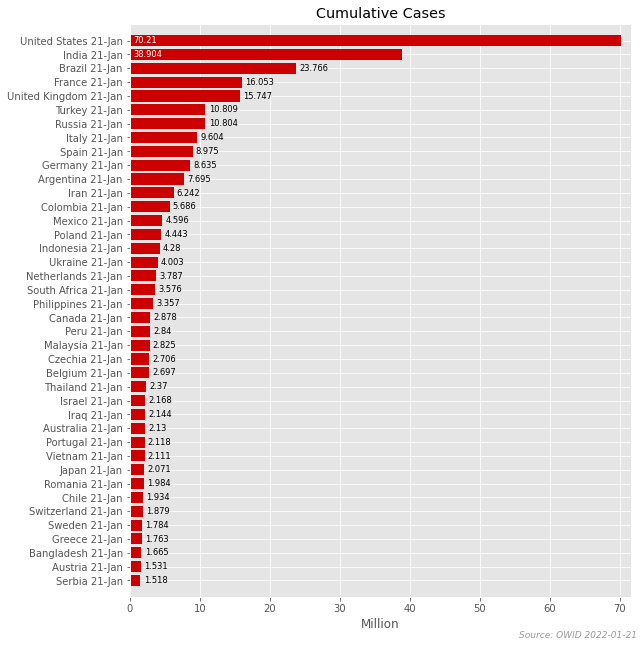

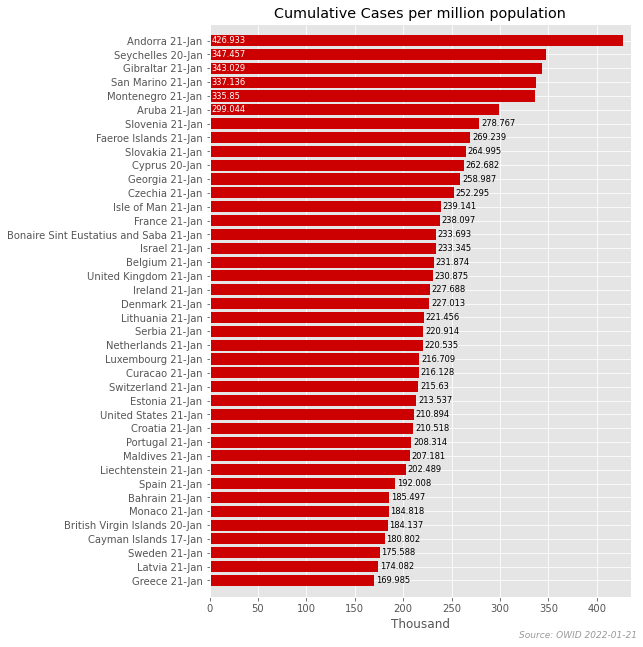

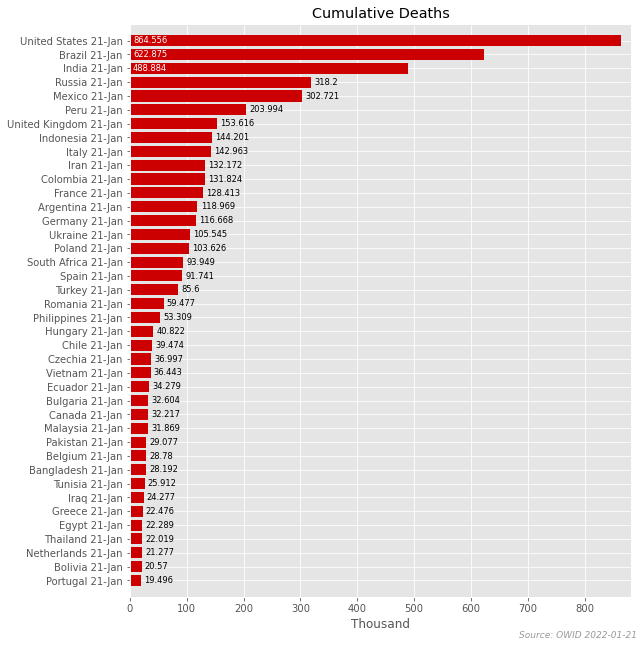

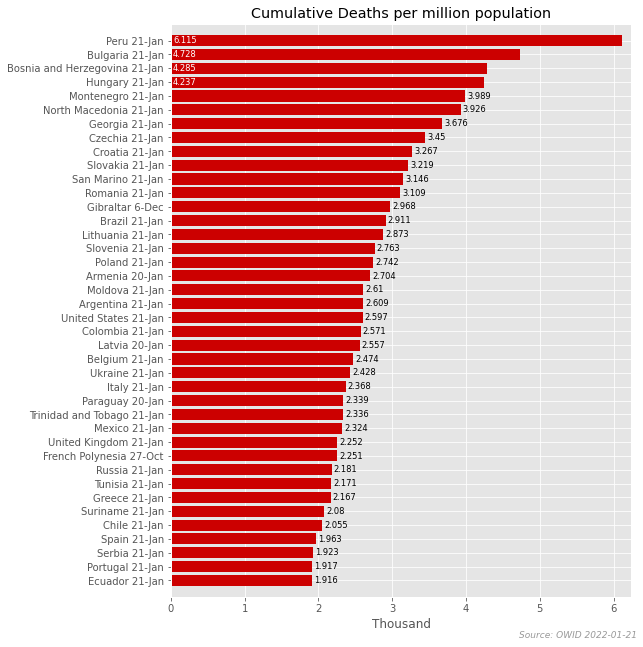

In [19]:
frame = {
    # name: description,
    'cases_raw_daily': 'Daily Cases',
    'deaths_raw_daily': 'Daily Deaths',
}

N = 7
for item, desc in frame.items():
    data = data_dict[item].rolling(N).mean()
    ps.plot_final_barh(data, 
                       title=f'Latest {desc.title()} ({N}-day moving average)', 
                       scale_x=True, 
                       set_size_inches=(9, 9), 
                       round=3,
                       no_locator=True,
                       color='#cc0000',
                       **std_plot_settings)
    
    data = (data / (data_dict['population'] / 1_000_000)).dropna(how='all', axis=1)
    ps.plot_final_barh(data, 
                       title=f'Latest {desc.title()} ({N}-day MA) per million population', 
                       scale_x=True, 
                       set_size_inches=(9, 9), 
                       round=3,
                       no_locator=True,
                       color='#cc0000',
                       **std_plot_settings)

frame = {
    # name: description,
    'cases': 'Cases',
    'deaths': 'Deaths',
}
for item, desc in frame.items():
    data = data_dict[item]
    ps.plot_final_barh(data, 
                       title=f'Cumulative {desc.title()}', 
                       scale_x=True, 
                       force_int=True,
                       set_size_inches=(9, 9), 
                       round=3,
                       no_locator=True,
                       color='#cc0000',
                       **std_plot_settings)
    
    data = (data / (data_dict['population'] / 1_000_000)).dropna(how='all', axis=1)
    ps.plot_final_barh(data, 
                       title=f'Cumulative {desc.title()} per million population', 
                       scale_x=True, 
                       set_size_inches=(9, 9), 
                       round=3,
                       no_locator=True,
                       color='#cc0000',
                       **std_plot_settings)



## Public health measures

In [20]:
fvr = data_dict['fully vaxxed rate']
si = data_dict['stringency index']

arguments = {
    **std_plot_settings,
    'ylabel': 'Index/Percent',
    'lw': 2.5,
    'show': False,
}

for nation in fvr.columns:
    if nation not in si.columns:
        continue
    df = (
        pd.DataFrame([fvr[nation].dropna(), si[nation].dropna()], 
                     index=['Fully Vaccinated', 'Public Health Stringency Index'])
        .T
    )
    df['Fully Vaccinated'] = df['Fully Vaccinated'].interpolate(method='linear')
    ps.plot_multiline(df, 
                      title=f'Public Health Measures - {nation}',
                      **arguments)

## Recent daily cases/deaths per million population

In [21]:
frame = {
    # name: description,
    'cases_adj_daily': 'Cases',
    'deaths_adj_daily': 'Deaths',
}

pop_in_millions = (data_dict['population'] / 1_000_000)

arguments = {
    **std_plot_settings,
    'recent': RECENT,
    'plot_type': 'scatter',
    #'scale_y': True,
    'func': ps.plot_series_with_ma,
    'lfoot_series': pop_in_millions,
    'lfoot_text': 'Population: {:,.3f} million',
    'show': False,
}

for item, desc in frame.items():
    df = (data_dict[item] / pop_in_millions).dropna(how='all', axis=1)
    ps.loop_over_frame(df, f'Daily New {desc} per Million Population', 
                       ylabel=f'{desc}/Million Pop.', **arguments)

## Weekly cases and deaths

In [22]:
frame = {
    # name: description,
    'cases_adj_daily': 'Cases',
    'deaths_adj_daily': 'Deaths',
}

plot_settings = {
    **std_plot_settings,
    'show': False,
}

In [23]:
for item, desc in frame.items():
    ps.loop_over_frame(df=data_dict[item], 
                desc=desc, 
                func=ps.plot_weekly, 
                scale_y=True,
                **plot_settings)


##    The End